# 分析用ノートブック

In [1]:
# レンダリング用のセルなので、実行するときはスキップしてください
import plotly.io as pio

pio.renderers.default = "png"

In [2]:
import sqlite3
import pickle

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import jquants_derivatives

In [3]:
save_fig = {}  # スライド表示用

## 原資産価格とインプライドボラティリティをキャッシュから取得

In [4]:
with sqlite3.connect(jquants_derivatives.database.db) as con:
    raw_data = pd.read_sql(
        "SELECT Date, UnderlyingPrice, ImpliedVolatility FROM OPTION_INDEX_OPTION", con
    )
s_iv = (
    raw_data.groupby("UnderlyingPrice", as_index=False)
    .first()
    .sort_values("Date")
    .loc[:, ["Date", "UnderlyingPrice", "ImpliedVolatility"]]
    .set_index("Date", drop=False)
    .loc["2019-01":]
)
s_iv.head()

,Date,UnderlyingPrice,ImpliedVolatility
Date,,,
2019-01-04 00:00:00,2019-01-04 00:00:00,19561.96,19.4353
2019-01-07 00:00:00,2019-01-07 00:00:00,20038.97,19.3641
2019-01-08 00:00:00,2019-01-08 00:00:00,20204.04,19.3571
2019-01-09 00:00:00,2019-01-09 00:00:00,20427.06,19.1474
2019-01-10 00:00:00,2019-01-10 00:00:00,20163.80,19.2240


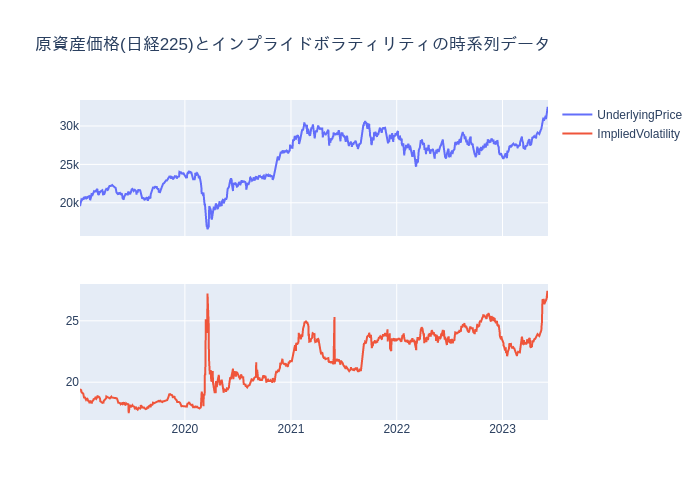

In [5]:
ts_fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
ts_fig.add_trace(
    go.Scatter(
        x=s_iv.loc[:, "Date"], y=s_iv.loc[:, "UnderlyingPrice"], name="UnderlyingPrice"
    ),
    row=1,
    col=1,
)
ts_fig.add_trace(
    go.Scatter(
        x=s_iv.loc[:, "Date"],
        y=s_iv.loc[:, "ImpliedVolatility"],
        name="ImpliedVolatility",
    ),
    row=2,
    col=1,
)
ts_fig.update_layout(go.Layout(title={"text": "原資産価格(日経225)とインプライドボラティリティの時系列データ"}))

In [6]:
save_fig["原資産価格(日経225)とインプライドボラティリティの時系列データ"] = ts_fig

## 原資産価格とボラティリティの騰落率

In [7]:
s_iv_pct_change = s_iv.loc[:, "UnderlyingPrice":].pct_change()
s_iv_pct_change.head()

,UnderlyingPrice,ImpliedVolatility
Date,,
2019-01-04 00:00:00,NaN,NaN
2019-01-07 00:00:00,0.024385,-0.003663
2019-01-08 00:00:00,0.008237,-0.000361
2019-01-09 00:00:00,0.011038,-0.010833
2019-01-10 00:00:00,-0.012888,0.004001


In [8]:
scatter_s_iv_fig = px.scatter(
    s_iv_pct_change,
    x="UnderlyingPrice",
    y="ImpliedVolatility",
    title="原資産価格とボラティリティの騰落率",
)

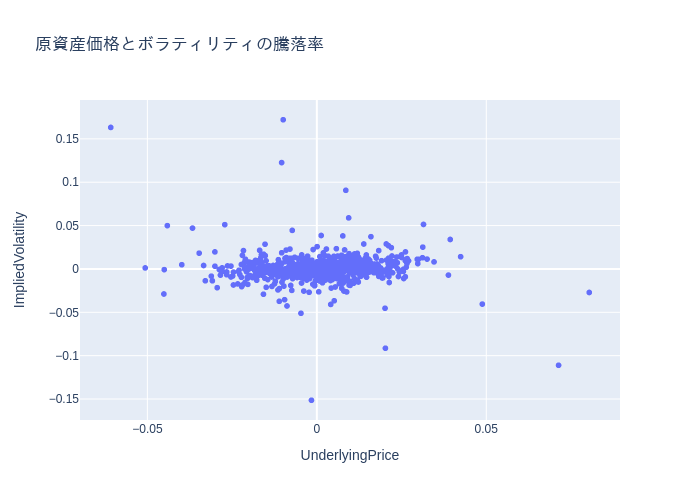

In [9]:
save_fig["原資産価格とボラティリティの騰落率"] = scatter_s_iv_fig
save_fig["原資産価格とボラティリティの騰落率"]

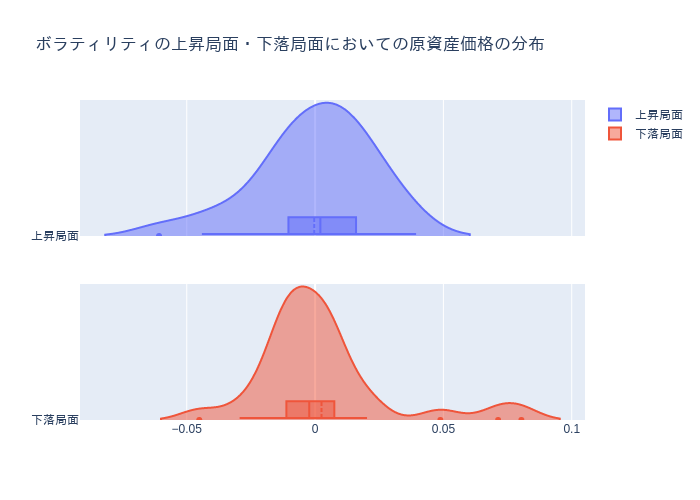

In [10]:
iv_upside = s_iv_pct_change.loc[s_iv_pct_change.loc[:, "ImpliedVolatility"] > 0.02]
iv_downside = s_iv_pct_change.loc[s_iv_pct_change.loc[:, "ImpliedVolatility"] < -0.02]

iv_updown_fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
iv_updown_fig.add_trace(
    go.Violin(
        x=iv_upside.loc[:, "UnderlyingPrice"],
        side="positive",
        box_visible=True,
        name="上昇局面",
    ),
    row=1,
    col=1,
)
iv_updown_fig.add_trace(
    go.Violin(
        x=iv_downside.loc[:, "UnderlyingPrice"],
        side="positive",
        box_visible=True,
        name="下落局面",
    ),
    row=2,
    col=1,
)
iv_updown_fig.update_traces(meanline_visible=True)
iv_updown_fig.update_layout(go.Layout(title={"text": "ボラティリティの上昇局面・下落局面においての原資産価格の分布"}))

In [11]:
save_fig["ボラティリティの上昇局面・下落局面においての原資産価格の分布"] = iv_updown_fig

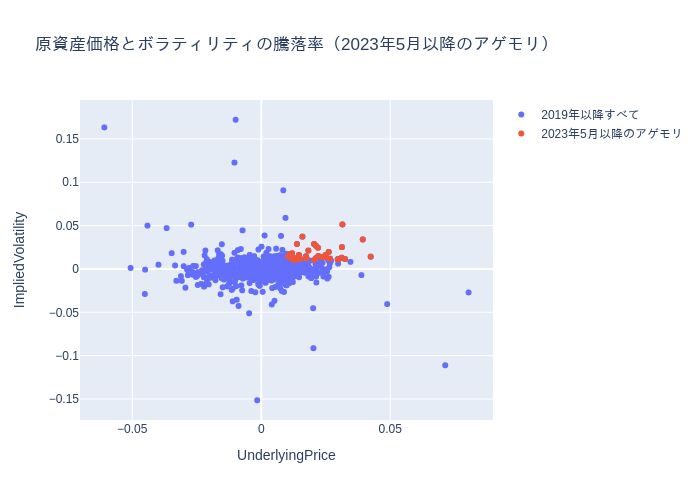

In [12]:
agemori = s_iv_pct_change.loc[(s_iv_pct_change > 0.01).all(axis=1), :]
scatter_s_iv_agemori_fig = go.Figure()
scatter_s_iv_agemori_fig.add_trace(
    go.Scatter(
        x=s_iv_pct_change.loc[:, "UnderlyingPrice"],
        y=s_iv_pct_change.loc[:, "ImpliedVolatility"],
        mode="markers",
        name="2019年以降すべて",
    )
)
scatter_s_iv_agemori_fig.add_trace(
    go.Scatter(
        x=agemori.loc[:, "UnderlyingPrice"],
        y=agemori.loc[:, "ImpliedVolatility"],
        mode="markers",
        name="2023年5月以降のアゲモリ",
    )
)
scatter_s_iv_agemori_fig.update_layout(
    go.Layout(
        title={"text": "原資産価格とボラティリティの騰落率（2023年5月以降のアゲモリ）"},
        xaxis={"title": "UnderlyingPrice"},
        yaxis={"title": "ImpliedVolatility"},
    )
)

In [13]:
save_fig["原資産価格とボラティリティの騰落率（2023年5月以降のアゲモリ）"] = scatter_s_iv_agemori_fig

## アゲモリ

In [14]:
agemori = s_iv_pct_change.loc[(s_iv_pct_change > 0.01).all(axis=1), :]
f"全データ: {len(s_iv_pct_change)}, アゲモリ局面: {len(agemori)}"

'全データ: 1076, アゲモリ局面: 39'

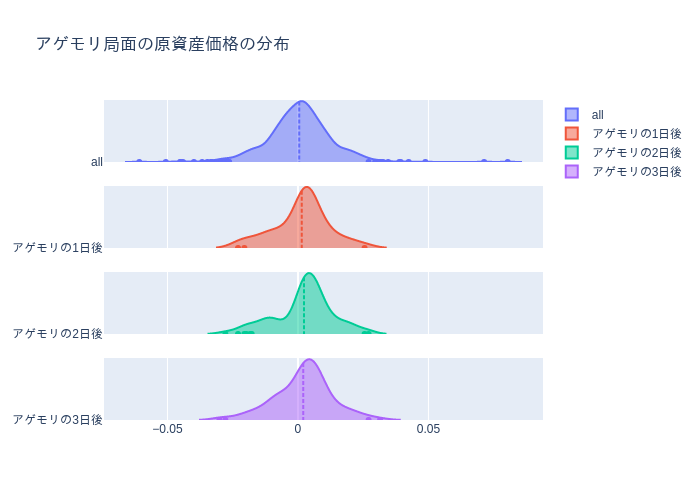

In [15]:
def get_agemori_next_days(days=1, col="UnderlyingPrice"):
    return pd.concat(
        [
            s_iv_pct_change.loc[agemori_day:, :].iloc[1 : days + 1]
            for agemori_day in agemori.index
        ]
    ).loc[:, col]


s_next_days = [get_agemori_next_days(i) for i in range(1, 4)]
iv_next_days = [get_agemori_next_days(i, "ImpliedVolatility") for i in range(1, 4)]

pct_change_fig = make_subplots(rows=4, cols=1, shared_xaxes=True)
pct_change_fig.add_trace(
    go.Violin(
        x=s_iv_pct_change.loc[:, "UnderlyingPrice"], side="positive", name="all"
    ),
    row=1,
    col=1,
)
for i in range(3):
    pct_change_fig.add_trace(
        go.Violin(x=s_next_days[i], side="positive", name=f"アゲモリの{i+1}日後"),
        row=i+2,
        col=1,
    )
pct_change_fig.update_traces(meanline_visible=True)
pct_change_fig.update_layout(go.Layout(title="アゲモリ局面の原資産価格の分布"))

In [16]:
save_fig["アゲモリ局面の原資産価格の分布"] = pct_change_fig

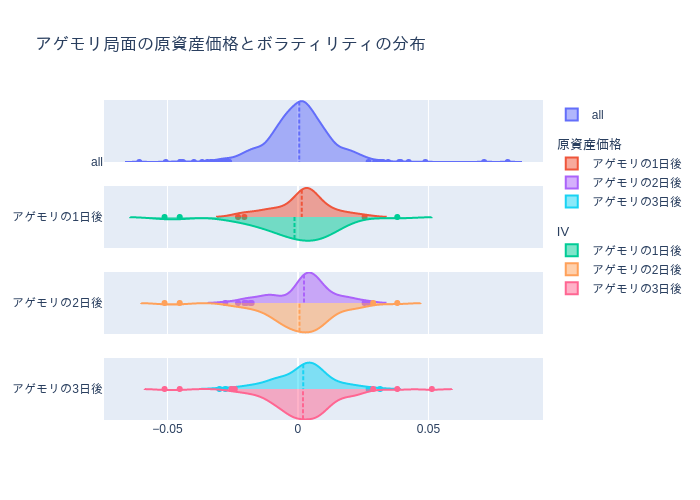

In [17]:
pct_change_vs_fig = make_subplots(rows=4, cols=1, shared_xaxes=True)
pct_change_vs_fig.add_trace(
    go.Violin(
        x=s_iv_pct_change.loc[:, "UnderlyingPrice"], side="positive", name="all"
    ),
    row=1,
    col=1,
)
for i in range(3):
    pct_change_vs_fig.add_trace(
        go.Violin(x=s_next_days[i], side="positive", name=f"アゲモリの{i+1}日後", legendgroup='s', legendgrouptitle_text="原資産価格", scalegroup='s'),
        row=i+2,
        col=1,
    )
    pct_change_vs_fig.add_trace(
        go.Violin(x=iv_next_days[i], side="negative", name=f"アゲモリの{i+1}日後", legendgroup='iv', legendgrouptitle_text="IV", scalegroup='iv'),
        row=i+2,
        col=1,
    )
pct_change_vs_fig.update_traces(meanline_visible=True)
pct_change_vs_fig.update_layout(go.Layout(title="アゲモリ局面の原資産価格とボラティリティの分布"))

In [18]:
save_fig["アゲモリ局面の原資産価格とボラティリティの分布"] = pct_change_vs_fig

## トレード戦略

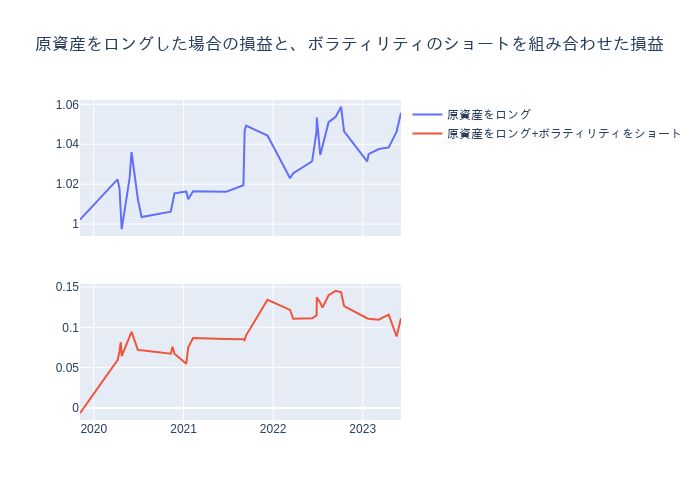

In [19]:
s_long = (1 + s_next_days[0]).cumprod()
s_long_and_iv_short = (1 + s_next_days[0]).cumprod() - (1 + iv_next_days[0]).cumprod()
pl_fig = make_subplots(rows=2, cols=1, shared_xaxes=True)
pl_fig.add_trace(
    go.Scatter(x=s_long.index, y=s_long, name="原資産をロング"),
    row=1,
    col=1,
)
pl_fig.add_trace(
    go.Scatter(
        x=s_long_and_iv_short.index,
        y=s_long_and_iv_short,
        name="原資産をロング+ボラティリティをショート",
    ),
    row=2,
    col=1,
)
pl_fig.update_layout(go.Layout(title={"text": "原資産をロングした場合の損益と、ボラティリティのショートを組み合わせた損益"}))

In [20]:
save_fig["原資産をロングした場合の損益と、ボラティリティのショートを組み合わせた損益"] = pl_fig

In [21]:
agemori.head()

,UnderlyingPrice,ImpliedVolatility
Date,,
2019-11-05 00:00:00,0.017558,0.012515
2020-04-06 00:00:00,0.042430,0.014142
2020-04-14 00:00:00,0.031266,0.025157
2020-04-17 00:00:00,0.031470,0.051309
2020-04-23 00:00:00,0.015231,0.011451


In [22]:
cli = jquants_derivatives.Client()
op_20191101 = jquants_derivatives.Option(cli.get_option_index_option("2019-11-01"))
op_20191105 = jquants_derivatives.Option(cli.get_option_index_option("2019-11-05"))
op_20191106 = jquants_derivatives.Option(cli.get_option_index_option("2019-11-06"))

In [23]:
s_20191105 = op_20191105.underlying_price["2019-12"]
c23500_20191105 = op_20191105.contracts_dfs["2019-12"].set_index("StrikePrice").loc[23500, "WholeDayClose"]
print(f"原資産価格: {s_20191105}, 23500コール価格:{c23500_20191105}")

原資産価格: 23251.99, 23500コール価格:290.0


In [24]:
s_20191106 = op_20191106.underlying_price["2019-12"]
c23500_20191106 = op_20191106.contracts_dfs["2019-12"].set_index("StrikePrice").loc[23500, "WholeDayClose"]
print(f"原資産価格: {s_20191106}, 23500コール価格:{c23500_20191106}")

原資産価格: 23303.82, 23500コール価格:295.0


In [25]:
pl = (s_20191106 - s_20191105) + (c23500_20191105 - c23500_20191106)
pl

46.82999999999811

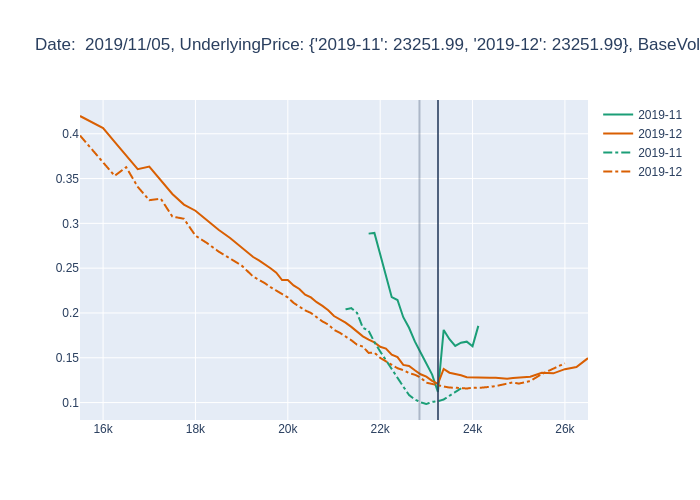

In [26]:
op_20191105_20191101_fig = jquants_derivatives.plot_volatility(op_20191105, op_20191101)
save_fig["2019年11月5日のボラティリティスマイル"] = op_20191105_20191101_fig
save_fig["2019年11月5日のボラティリティスマイル"]

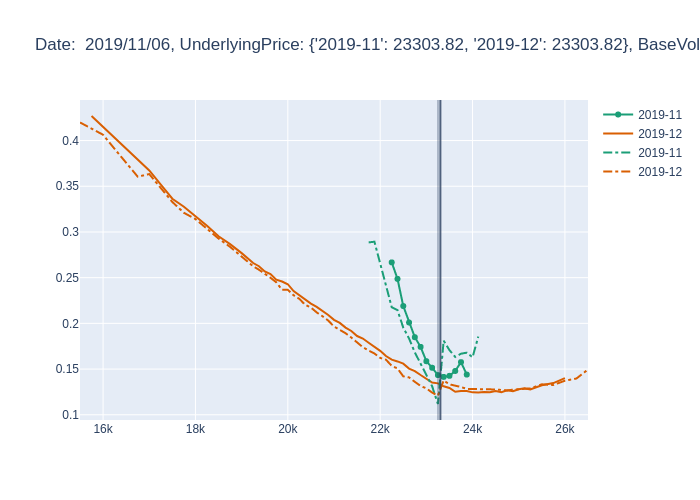

In [27]:
op_20191106_20191105_fig = jquants_derivatives.plot_volatility(op_20191106, op_20191105)
save_fig["2019年11月6日のボラティリティスマイル"] = op_20191106_20191105_fig
save_fig["2019年11月6日のボラティリティスマイル"]

In [28]:
with open("save_fig.pickle", "wb") as f:
    pickle.dump(save_fig, f)